In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [10]:
plt.rcParams['figure.figsize'] = [20, 10]

In [11]:
def read_td_log_running(fname, minl):
    file = open(fname, 'r')
    x = []
    baseline, tdnn, tdsnn, tdsnnv  = [], [], [], []
    next(file)
    for line in file.readlines()[:minl]:
        it,current,target,random_prediction,tdnn_prediction,tdsnn_prediction,tdsnn_softmax_prediction,tdnn_tl = line.replace('\n','').split(',')
        x.append(float(it))
        baseline.append(float(target==random_prediction))
        tdnn.append(float(target==tdnn_prediction))
        tdsnn.append(float(target==tdsnn_prediction))
        tdsnnv.append(float(target==tdsnn_softmax_prediction))
    return x, baseline, tdnn, tdsnn, tdsnnv

In [12]:
def read_lstm_log(fname):
    file = open(fname, 'r')
    x = []
    accuracy = []
    next(file)
    for line in file.readlines():
        it, current, target, prediction, correct = line.replace('\n','').split(',')
        x.append(float(it))
        accuracy.append(float(correct))
    return x, accuracy

In [13]:
def moving_average(a, n):
    moving_average = []
    for i in range(len(a)):
        start = max(0, i - n)
        values = a[start:i+1]
        moving_average.append(np.sum(values) / float(len(values)))
    return np.array(moving_average)

In [14]:
td_logs = ['td/'+i for i in os.listdir('./td/') if '.out' in i]
minl = float('inf')
for log in td_logs:
    file = open(log, 'r')
    minl = min(minl, len(file.readlines())-2)

In [15]:
lstm_logs = ['lstm/'+i for i in os.listdir('./lstm/') if '.log' in i]

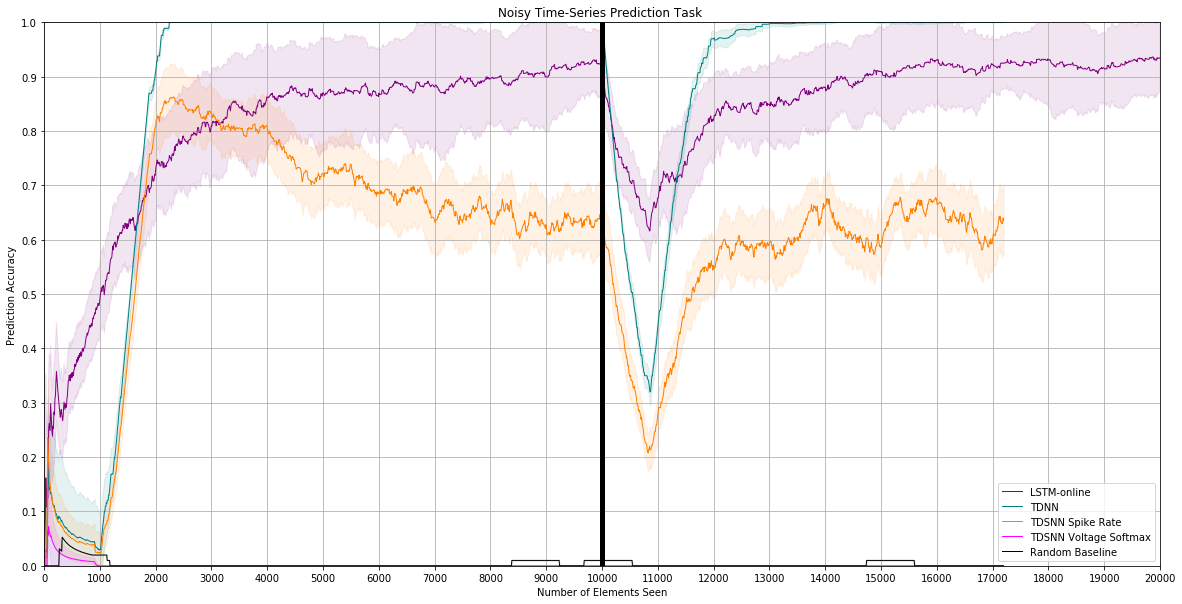

In [16]:
baseline_acc, tdnn_acc, tdsnn_acc, tdsnnv_acc = [], [], [], []
td_x = None
for log in td_logs:
    td_x, baseline, tdnn, tdsnn, tdsnnv = read_td_log_running(log, minl)
    baseline_acc.append(moving_average(baseline, min(len(baseline), 100)))
    tdnn_acc.append(moving_average(tdnn, min(len(tdnn), 100)))
    tdsnn_acc.append(moving_average(tdsnn, min(len(tdsnn), 100)))
    tdsnnv_acc.append(moving_average(tdsnnv, min(len(tdsnnv), 100)))
    
lstm_acc = []
lstm_x = None
for log in lstm_logs:
    lstm_x, lstm = read_lstm_log(log)
    lstm_acc.append(moving_average(lstm, min(len(lstm), 100)))
    
def plot(x, acc, label, color, lw=1):
    plt.plot(x, np.mean(acc, axis=0), label=label, linewidth=lw, color=color)
    plt.fill_between(x, (np.mean(acc, axis=0)+np.std(acc, axis=0)), (np.mean(acc, axis=0)-np.std(acc, axis=0)), color=color+[0.1])
    
plot(lstm_x,lstm_acc,'LSTM-online', [0.5, 0, 0.5])
plot(td_x,tdnn_acc,'TDNN', [0, 0.5, 0.5])
plot(td_x,tdsnn_acc,'TDSNN Spike Rate', [1, 0.5, 0])
plot(td_x,tdsnnv_acc,'TDSNN Voltage Softmax', [1, 0, 1])
plot(td_x,baseline_acc,'Random Baseline', [0, 0, 0])

plt.plot([10000, 10000], [0, 1], linewidth=5, color='black')
plt.ylim(0, 1.0)
plt.xlim(0, 20000)
plt.yticks(np.linspace(0, 1, 11))
plt.xticks(np.arange(0, 20001, 1000))
plt.title('Noisy Time-Series Prediction Task ')
plt.ylabel('Prediction Accuracy')
plt.xlabel('Number of Elements Seen')
plt.grid()
plt.legend(loc='lower right')
plt.savefig('results.png', dpi=150)
plt.savefig('results.pdf', dpi=150)